In [1]:
import os
import torch
import shutil
import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt

from typing import List

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pytorch_lightning as pl
import torchmetrics
import segmentation_models_pytorch as smp


#import albumentations as A
#from albumentations.pytorch import ToTensorV2

import evidence_loss
import torch.nn.functional as F

from torch import Tensor


In [2]:
from kornia import image_to_tensor, tensor_to_image
from kornia.augmentation import ColorJitter, RandomChannelShuffle, RandomThinPlateSpline
from kornia.augmentation import RandomVerticalFlip, RandomHorizontalFlip, Resize, RandomCrop, RandomMotionBlur
from kornia.augmentation import RandomEqualize, RandomGaussianBlur, RandomGaussianNoise, RandomSharpness
import kornia as K

## Dataloader

In [3]:
class DataAugmentation(torch.nn.Module):
    """Module to perform data augmentation using Kornia on torch tensors."""

    def __init__(self, apply_color_jitter: bool = False) -> None:
        super().__init__()
        self._apply_color_jitter = apply_color_jitter

        self.transforms = torch.nn.Sequential(
            #RandomHorizontalFlip(p=0.50),
            RandomChannelShuffle(p=0.50),
            RandomThinPlateSpline(p=0.50),
            RandomEqualize(p=0.5),
            RandomGaussianBlur((3, 3), (0.1, 2.0), p=0.2),
            RandomGaussianNoise(mean=0., std=1., p=0.2),
            RandomSharpness(0.5, p=0.5)
        )

        
        self.jitter = ColorJitter(0.5, 0.5, 0.5, 0.5)

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x: Tensor) -> Tensor:
        #x = torch.squeeze(x, dim=1)
        x_out = self.transforms(x)  # BxCxHxW
        if self._apply_color_jitter:
            x_out = self.jitter(x_out)
        return x_out
    
class Preprocess(torch.nn.Module):
    """Module to perform pre-process using Kornia on torch tensors."""
    def __init__(self) -> None:
        super().__init__()
        #self.resize = Resize(size=(224,224))
        #self.crop = RandomCrop(size=(64,64), cropping_mode="slice")

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, image, mask) -> Tensor:
        x_tmp: np.ndarray = np.array(image)  # HxWxC
        x_out: Tensor = image_to_tensor(x_tmp, keepdim=True)  # CxHxW
        #x_out: Tensor = self.resize(x_out.float()).squeeze(dim=0)
        x_tmp: np.ndarray = np.array(mask)  # HxWxC
        mask_out: Tensor = image_to_tensor(x_tmp)
        #mask_out: Tensor = self.resize(mask_out.float()).squeeze(dim=0)
        return x_out.float() / 255.0, mask_out.long()

In [4]:
x = np.random.rand(5,5)
x = image_to_tensor(x, keepdim=True)
resize = Resize(size=(3,3))
resize(x.float()).squeeze(dim=0)

tensor([[[0.2468, 0.9330, 0.1222],
         [0.3383, 0.7411, 0.8678],
         [0.9315, 0.7033, 0.9480]]])

In [5]:

class SingleImageVirtualKittiDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        root: str, 
        mode: str = "train", 
        transforms = None):

        assert mode in {"train", "valid", "test"}
        
        self.mode = mode
        self.transforms = transforms

        self.files_directory = root
  
        self.scene_folder_name = ['Scene01','Scene02','Scene06','Scene18','Scene20']
        self.scenario_folder_name = ['15-deg-left','15-deg-right','30-deg-left',
                                 '30-deg-right','clone','fog','morning',
                                 'overcast','rain','sunset']
        self.data_folder_name = ['classSegmentation','rgb']
        self.file_prefix_name = ['classgt', 'rgb']
        self.file_format_name = ['png', 'jpg']
        self.output_name = ['mask', 'image']
        self.camera_folder_name = ['Camera_0', 'Camera_1']
        self.data_column_names=['scene', 'scenario', 'camera_number', 'frame_number']
        
        #Filenames extracted as a pandas dataframe
        self.filenames = self._read_split()  # read train/valid/test splits
        self.mask_colors = pd.read_csv(os.path.join(self.files_directory, 
                                               self.scene_folder_name[0], 
                                               self.scenario_folder_name[0],
                                               'colors.txt'), 
                                       delimiter=' ')
        self.mask_colors['mask_label'] = self.mask_colors.index
        #Replacing the follwing
        #[GuardRail, TrafficLight, Pole, Truck, Van, Undefined] -> 
        #[Misc,      TrafficSign,  Misc, Car,   Car, Misc]
        self.mask_colors['mask_label'] =self. mask_colors['mask_label'].replace([6, 9, 10, 14, 7, 8, 11, 12, 13], 
                                                                    [8, 8, 8, 8, 6, 6, 7, 7, 7])
        print ("Total classes ", len(self.mask_colors['mask_label'].unique()))
        print ("Total classes ", (self.mask_colors['mask_label'].unique()))
        #Final classes are
        self.mask_colors = self.mask_colors.values.tolist()
      
    def __len__(self) -> int:
        return len(self.filenames)
    def __getitem__(self, idx: int) -> dict:

        scene, scenario, camera, frame_number = self.filenames[idx]
        sample = {}
        for folder, prefix, file_format, output in zip(self.data_folder_name, 
                                               self.file_prefix_name,
                                               self.file_format_name,
                                               self.output_name):
            frame_name = prefix+'_'+frame_number+'.'+file_format
            image_path = os.path.join(self.files_directory, 
                                      scene, 
                                      scenario, 
                                      'frames', 
                                      folder, 
                                      camera, 
                                      frame_name)
            sample[output] = np.array(Image.open(image_path))
           

        sample['mask'] = self._preprocess_mask(sample['mask'])

        # convert to other format HWC -> CHW
        #sample["image"] = np.moveaxis(sample["image"], -1, 0)
        #sample["mask"] = np.expand_dims(sample["mask"], 0)
        
        
        #Applies transformation and converts to tensor
        if self.transforms is not None:            
            transformed = self.transforms(image=sample['image'], mask=sample['mask'])

            sample['image'] = transformed['image']
            sample['mask'] = transformed['mask'].long()
        

        return sample
    
    def _preprocess_mask(self, mask: np.ndarray) -> np.ndarray:
        ''' 
        Convert RGB mask to single channel mask based on the color value
        provided in color.txt file 
        
        Parameters:
            mask: Numpy array mask of shape [height, width, 3]
            out: Numpy array of shape [height, width]
        '''
        preprocessed_mask = np.zeros(mask.shape[:2])
        for index, row in enumerate(self.mask_colors):
            # The columns of  mask_color dataframe is ['Terrain', r, g, b, mask_label]
            idx = np.all(mask == (row[1], row[2], row[3]), axis=-1) #
            preprocessed_mask[idx] = row[4]

        return preprocessed_mask

    def _read_split(self) -> list:
        ''' 
        Parses the virual kitti dataset and converts to a pandas dataframe
        
        Parameters:
            out: A list
        '''
        filenames = []
        for scene in self.scene_folder_name:
            for scenario in self.scenario_folder_name:
                #extrinsic = pd.read_csv(os.path.join(self.files_directory, scene, scenario,'extrinsic.txt'),
                #                        delimiter=' ')
                for camera in self.camera_folder_name:
                    single_filenames = os.listdir(os.path.join(self.files_directory, 
                                                               scene, 
                                                               scenario, 
                                                               'frames', 
                                                               'rgb', 
                                                               camera))
                    single_filenames.sort()
                    for f in single_filenames:
                        #Splitting filename rgb_0000.jpg first replacing '.' with '_'
                        _, frame_number, _ = f.replace('.','_').split('_') 
                        _, camera_number = camera.split('_')
                        #Loc is a slow query 

                        filenames.append([scene, scenario, camera, frame_number])

        filenames = pd.DataFrame(filenames, columns=self.data_column_names)
        

 

        if self.mode == "train":  # 90% for train
            # Creating a dataframe with 50%
            filenames = filenames.sample(frac = 0.6, random_state=55)
        elif self.mode == "valid":  # 10% for validation
            #sampling the same files with the random_state and droping them
            train_filenames = filenames.sample(frac = 0.4, random_state=55)
            filenames = filenames.drop(train_filenames.index)
            
        return filenames.values.tolist()



#### Single image Data loader 

batch = 
batch['image'] -> [bs, 3, height, width]
batch['mask '] -> [bs, 1, height, width]

#### Sequence image Data loader 
batch['image1'] -> [bs, 3, height, width]
batch['mask1'] -> [bs, 1, height, width]
batch['image2'] -> [bs, 3, height, width]
batch['mask2'] -> [bs, 1, height, width]
batch['depth'] -> [bs, 1, height, width]
batch['rotation_from_1_to_2'] -> np.array
batch['translation_from_1_to_2'] -> np.array

## Albumnetation 

In [5]:

def pre_transforms(image_size=224):
    return [A.Resize(image_size, image_size, p=1)]


def hard_transforms():
    result = [
      A.CoarseDropout(),
      A.RandomBrightnessContrast(
          brightness_limit=0.2, contrast_limit=0.2, p=0.3
      ),
      A.GridDistortion(p=0.3),
      A.HueSaturationValue(p=0.3)
    ]

    return result
  

def resize_transforms(image_size=224):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose([
      A.SmallestMaxSize(pre_size, p=1),
      A.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    rescale = albu.Compose([A.Resize(image_size, image_size, p=1)])

    random_crop_big = albu.Compose([
      A.LongestMaxSize(pre_size, p=1),
      A.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    # Converts the image to a square of size image_size x image_size
    result = [
      A.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
  
def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = A.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

## Lightning model

In [28]:
class VirtualKittiDataset(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        
        self.transform = DataAugmentation()  # per batch augmentation_kornia
     
        # for image segmentation dice loss could be the best first choice
        #self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
        self.loss_fn = evidence_loss.edl_mse_loss
        self.n_classes = out_classes
        
        self.epoch = 0
        self.lr = 0.0001
        
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.train_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes)
        self.valid_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes)
        

    def forward(self, image):
        # normalize image here
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4
        bs, num_channels, height, width = image.size()

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        
        # Shape of the mask should be [batch_size, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 3
        
        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 255.0 and mask.min() >= 0
      
        #unroll the tensor to single tensor 
        # [batch_size, height, width] -> [batch_size*height*width]
        mask = torch.ravel(mask)
        # [batch_size*height*width] -> [batch_size*height*width, n_classes] 
        mask = F.one_hot(mask.to(torch.long), self.n_classes)
        
        logits_mask = self.forward(image)
        # [batch_size, n_classes, height, width] -> [batch_size,n_classes, height*width]
        logits_mask = logits_mask.view(bs, self.n_classes, -1) 
        # [batch_size,n_classes, height*width] -> [batch_size, height*width, n_classes]
        logits_mask = logits_mask.permute(0,2,1)
        # [batch_size, height*width, n_classes] -> [batch_size*height*width, n_classes]
        logits_mask = logits_mask.reshape_as(mask)
        
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask, self.epoch, self.n_classes, 10)
   
        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        #prob_mask = logits_mask.sigmoid()
        #pred_mask = (prob_mask > 0.5).float()
        logits_mask = torch.relu(logits_mask) + 1
        pred_mask = logits_mask.argmax(dim=1, keepdim=True)
        mask = mask.argmax(dim=1, keepdim=True)
        #print ("prob mask ",prob_mask.shape)
        #print ("pred mask ",pred_mask.shape)
        #print (" mask ", mask.shape)
      
        if 'train' == stage:
            self.train_cm(pred_mask, mask)
        elif 'valid' == stage:
            self.valid_cm(pred_mask, mask)
            
        #Changing back to original dimension for metrics calculation
        pred_mask = pred_mask.reshape(bs, 1, height, width )
        mask = mask.reshape(bs, 1, height, width)
        
        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), 
                                               mask.long(), 
                                               mode="multiclass", 
                                               num_classes=self.n_classes)
        
        
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
           # "confusion_matrix":confusion_matrix,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        
       
        # aggregate step metics
        loss = [x["loss"].item() for x in outputs]
        
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_evidential_loss": loss,
        }
        
        self.log_dict(metrics, prog_bar=True)

            
        
        self.epoch += 1
        
    def on_after_batch_transfer(self, batch, dataloader_idx):
        x, y = batch
        if self.trainer.training:
            x = self.transform(x)  # => we perform GPU/Batched data augmentation
        return x, y

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        out = self.shared_epoch_end(outputs, "train")
        # turn confusion matrix into a figure (Tensor cannot be logged as a scalar)
        fig = plt.figure()
        plt.imshow(self.train_cm.compute().cpu().numpy())
        # log figure
        self.logger.experiment.add_figure('train_epoch_confmat', fig, global_step=self.global_step)
    
        self.train_cm.reset()
        return out

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid") 

    def validation_epoch_end(self, outputs):
        out = self.shared_epoch_end(outputs, "valid")
        # turn confusion matrix into a figure (Tensor cannot be logged as a scalar)
        fig = plt.figure()
        plt.imshow(self.valid_cm.compute().cpu().numpy())
        # log figure
        self.logger.experiment.add_figure('valid_epoch_confmat', fig, global_step=self.global_step)
    
        self.valid_cm.reset()
        return out

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## Training

In [6]:
train_transforms = compose([
    #resize_transforms(),  #There seems to be error in finding the proper crop size
    pre_transforms(),
    #hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])



In [39]:
kornia_transform = Preprocess()

In [40]:
root = '/home/deebuls/Documents/phd/dataset/virtual_kitti/'

valid_dataset = SingleImageVirtualKittiDataset(root, "valid", transforms=kornia_transform)

train_dataset = SingleImageVirtualKittiDataset(root, "train", transforms=kornia_transform)

loaders = {
    "train": DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=int(14)), 
    "valid": DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=int(16/2)),
}

Total classes  9
Total classes  [0 1 2 3 4 5 8 6 7]
Total classes  9
Total classes  [0 1 2 3 4 5 8 6 7]


In [41]:
len(valid_dataset)

4252

In [42]:
len(train_dataset)

38268

In [43]:
model = VirtualKittiDataset("FPN", 
                            "timm-mobilenetv3_small_minimal_100", 
                            in_channels=3, 
                            out_classes=9,
                           )
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=2,
    #callbacks=[pl.callbacks.StochasticWeightAveraging(swa_lrs=1e-2)],
    #auto_lr_find=True,
    profiler="simple",
    precision=16
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [44]:
trainer.fit(
    model, 
    train_dataloaders=loaders['train'], 
    val_dataloaders=loaders['valid'],
)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | FPN              | 2.2 M 
1 | transform | DataAugmentation | 0     
2 | train_acc | Accuracy         | 0     
3 | valid_acc | Accuracy         | 0     
4 | train_cm  | ConfusionMatrix  | 0     
5 | valid_cm  | ConfusionMatrix  | 0     
-----------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.899     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_194145/1217064345.py", line 76, in __getitem__
    sample['image'] = transformed['image']
TypeError: tuple indices must be integers or slices, not str


```
# Autoscale batch size
trainer = pl.Trainer(auto_scale_batch_size="binsearch")

# Find the batch size
trainer.tune(model)
````
#####  ouptut
Batch size 2 succeeded, trying batch size 4
Batch size 4 succeeded, trying batch size 8
Batch size 8 succeeded, trying batch size 16
Batch size 16 succeeded, trying batch size 32
Batch size 32 succeeded, trying batch size 64
Batch size 64 succeeded, trying batch size 128
Batch size 128 succeeded, trying batch size 256

### VAlidation

In [117]:
model.model = torch.load('./vkitti_mobilenetv3_20epoch.pt')

In [118]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=loaders['valid'], verbose=False)
print(valid_metrics)
#pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

VALIDATE Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
-------------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  106.79         	|  100 %          	|
-------------------------------------------------------------------------------------------------------------------------------------------
run_validate_evaluation            	|  104.27         	|1              	|  104.27         	|  97.636         	|
get_validate_batch                 	|  0.64091        	|134            	|  85.882         	|  80.42          	|
fetch_next_validate_batch          	|  0.64089        	|134            	|  85.879         	|  80.417         	|
evaluation_step_and_end            	|  0.1226         	|133            	|  16.306         	|  15.269         	|
validation_step     

[{'valid_per_image_iou': 0.38405269384384155, 'valid_dataset_iou': 0.37066951394081116}]


In [105]:
from torchmetrics import ConfusionMatrix
import matplotlib
from sklearn.metrics import ConfusionMatrixDisplay


cmat = ConfusionMatrix(num_classes=9)

for batch in loaders['valid']:
    print (batch["image"].shape)
    bs, num_channels, height, width = batch["image"].size()
    with torch.no_grad():
        logits_mask = model(batch["image"])
    #unroll the tensor to single tensor 
    # [batch_size, height, width] -> [batch_size*height*width]
    mask = torch.ravel(batch["mask"])
    
    # [batch_size, n_classes, height, width] -> [batch_size,n_classes, height*width]
    #logits_mask = logits_mask.view(bs, 9, -1) 
    # [batch_size,n_classes, height*width] -> [batch_size, height*width, n_classes]
    logits_mask = logits_mask.permute(0,2,3,1)
    # [batch_size, height*width, n_classes] -> [batch_size*height*width, n_classes]
    logits_mask = logits_mask.reshape(-1, 9)
    
    logits_mask = torch.relu(logits_mask) + 1
    pred_mask = logits_mask.argmax(dim=1, keepdim=True)
    
    cmat(pred_mask, mask)

cmat_tensor = cmat.compute()
cmat = cmat_tensor.numpy()

disp = ConfusionMatrixDisplay(cmat)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()


torch.Size([32, 3, 224, 224])


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


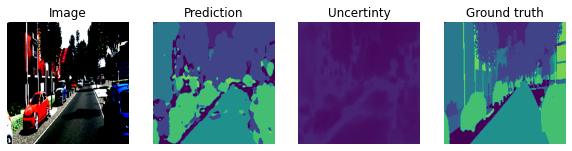

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


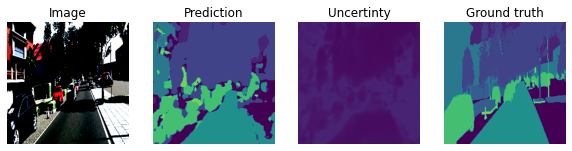

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


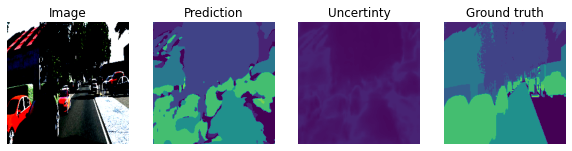

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


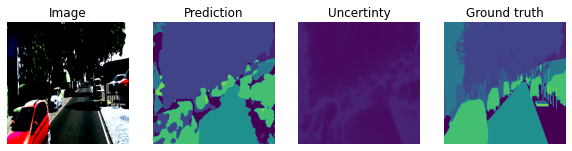

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


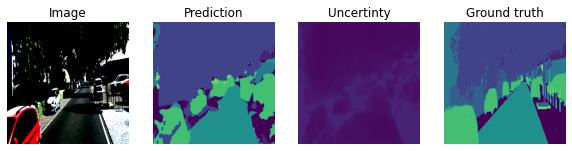

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


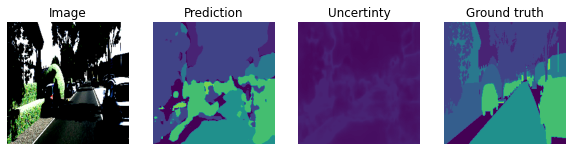

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


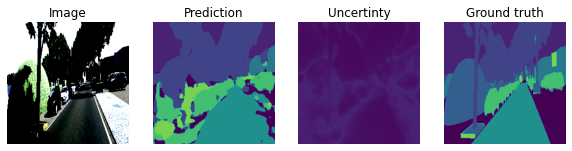

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


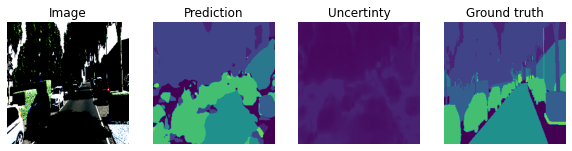

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


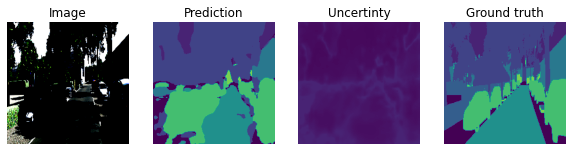

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


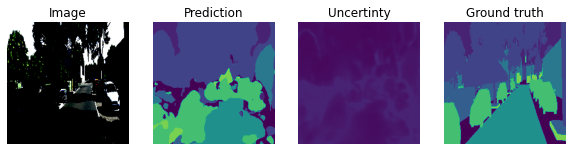

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


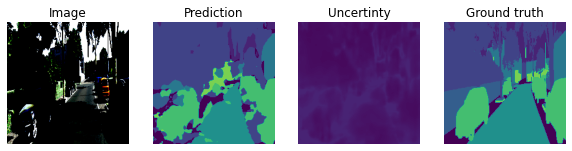

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


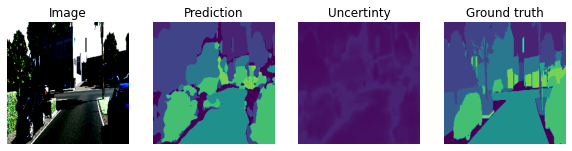

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


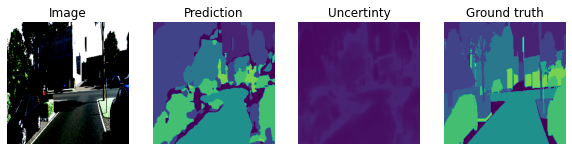

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


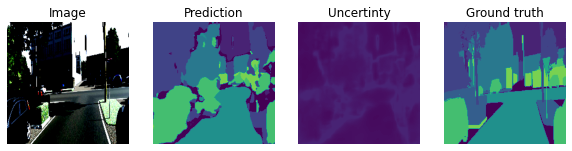

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


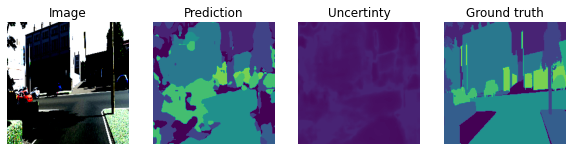

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


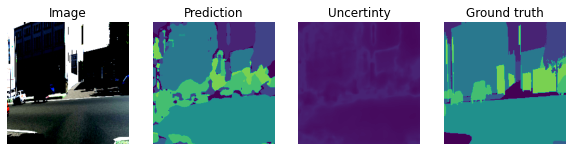

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


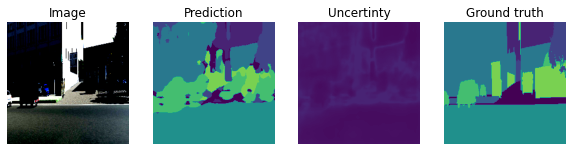

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


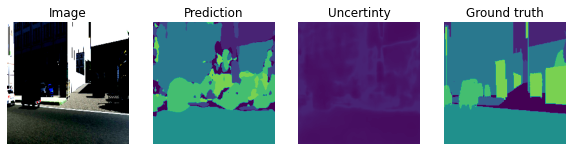

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


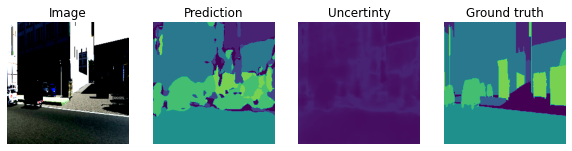

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


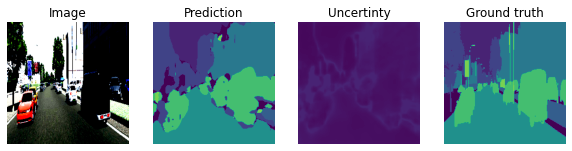

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


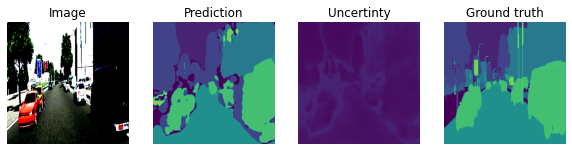

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


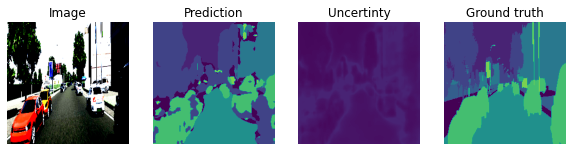

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


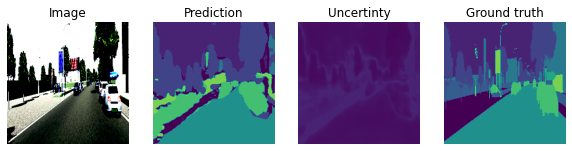

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


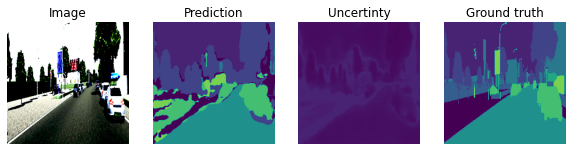

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


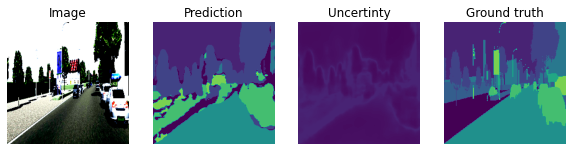

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


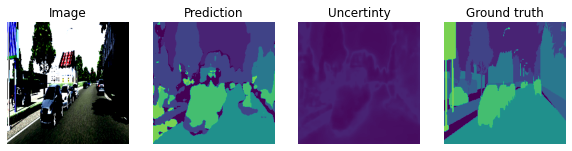

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


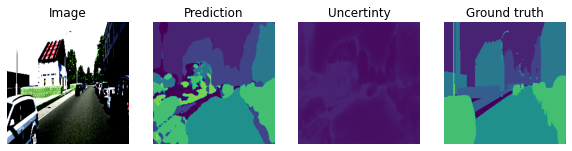

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


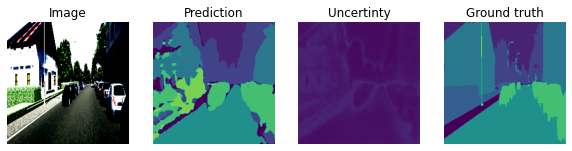

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


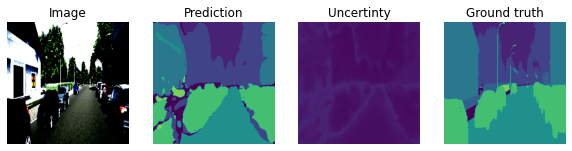

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


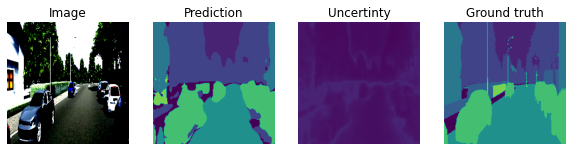

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


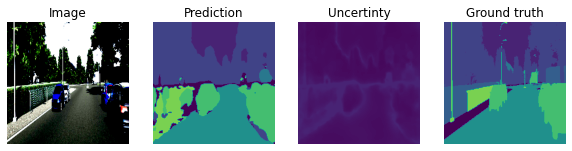

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


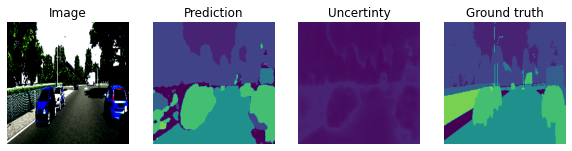

In [13]:
batch = next(iter(loaders['valid']))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
#pr_masks = logits.sigmoid()
#prob_mask = logits.log_softmax(dim=1).exp()
evidence  = torch.relu(logits)
alpha = evidence + 1
pred_mask = alpha.argmax(dim=1, keepdim=True)
sum_evidence = torch.sum(alpha, dim=1, keepdim=True)
uncertainty = 9 / sum_evidence
#print (sum_evidence.shape, uncertainty.shape)
for image, gt_mask, pr_mask, u in zip(batch["image"], batch["mask"], pred_mask, uncertainty):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(gt_mask.numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(pr_mask.numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")
  
    plt.subplot(1, 4, 3)
    plt.imshow(u.numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("Uncertinty")
    plt.axis("off")
    
    #plt.savefig('result.png')
    plt.show()
    


In [11]:
torch.save(model.model, './vkitti_mobilenetv3_20epoch.pt')

In [15]:
alpha.long().unique(return_counts=True)

(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
         37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 tensor([12872369,   201450,   152451,   120382,    99668,    86999,    79847,
            73650,    67640,    61752,    58119,    55734,    53996,    51987,
            49033,    44948,    41014,    36173,    31562,    28747,    26059,
            23595,    21210,    18678,    16402,    13728,    12033,    10909,
             8717,     7495,     6410,     4846,     3488,     2610,     2063,
             1506,     1138,      863,      597,      401,      192,       91,
               61,       56,       11,        6,        2]))

In [3]:
%%time

import random
import copy
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    #dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image = dataset[idx]
        ax[i, 0].imshow(image['image'].permute(1,2,0))
        ax[i, 1].imshow(image['mask'], interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

    
root = '/home/deebuls/Documents/phd/dataset/virtual_kitti/'

#valid_transforms = A.Compose([A.Normalize, ToTensorV2])
valid_dataset = SingleImageVirtualKittiDataset(root, 
                                               "valid", 
                                               transforms=valid_transforms)
#valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=int(16/2))
 
random.seed(2)
visualize_augmentations(valid_dataset, idx=89)



NameError: name 'valid_transforms' is not defined